<a href="https://colab.research.google.com/github/HarlinLee/science4cast/blob/main/feature_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from scipy import sparse, stats
import numpy as np
import pickle
from datetime import date, datetime
import json
import os

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from tensorflow import keras

from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/My Drive/science4cast"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def save_feature(mat, fname, path=DRIVE_PATH):
    with open(os.path.join(path, 'features', fname+'.npz'), "wb") as f:
        np.savez_compressed(f, a=mat)
    return 0

def load_feature(fname, path=DRIVE_PATH):
    with np.load(os.path.join(path, 'features', fname+'.npz'), allow_pickle=True) as dat:
        return dat['a']

In [3]:
def generate_train(data, batch_size):
    d0, d1 = data
    while True:
        idx0 = np.random.choice(len(d0), batch_size)
        yield d0[idx0], d1[idx0]
        
def generate_test(data, batch_size):
    data_len = len(data)
    idx_start = 0
    while True:
        idx0 = range(idx_start, min(idx_start+batch_size, data_len))
        idx_start += batch_size

        yield data[idx0]

# Load all features

In [4]:
train_edges_for_checking = load_feature('edges')
train_edges_solution = load_feature('train_solutions')
unconnected_vertex_pairs = load_feature('unconnected_vertex_pairs')

# 15 link prediction features
names = ['Node Degree 1', 'Node Degree 2', 'Preferential Attachment', 'Katz Node 1', 'Katz Node 2', 'Common Neighbors', 
 'Leicht-Holme-Newman Index', 'Salton Cosine Formula', 'Hub Promoted Index', 'Hub Depressed Index', 'Sorenson Index', 'Jaccard Coeffcient',
 'Path Length 2 to Node 1', 'Path Length 2 to Node 2', 'Pref. Attachment Paths']
 
# 15 link prediction features x 3 years
train_features = load_feature('train_features')
eval_features = load_feature('eval_features')

# 2 embedding features 
l2_yrs = range(-1, -10, -2)
cos_yrs = range(-2, -10-1, -2)

# 2 embedding features x 5 years
embed_features = load_feature('embed_features')
eval_embed_features = load_feature('eval_embed_features')

# Train model

In [5]:
(   idx_train,
    idx_test,
    labels_train,
    labels_test,
) = train_test_split(range(len(train_edges_solution)), train_edges_solution, train_size=0.95, test_size=0.05)

data_train = np.hstack((train_features[idx_train], embed_features[idx_train]))
data_test = np.hstack((train_features[idx_test], embed_features[idx_test]))
data_eval = np.hstack((eval_features, eval_embed_features))

print(data_train.shape, data_test.shape, data_eval.shape)

(5470944, 55) (287945, 55) (1000000, 55)


In [6]:
input_shape = (data_train.shape[1],)
dropout_rate = 0.2

model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy, keras.metrics.AUC()],
    )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               28672     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [7]:
batch_size = 128

model.fit(generate_train((data_train, labels_train),  batch_size),
          steps_per_epoch = 30000,
          epochs = 50,
          verbose = 2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=1, restore_best_weights=True),
                    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=0, min_lr=5e-6)
                    ],
          use_multiprocessing=False
         )

Epoch 1/50
30000/30000 - 363s - loss: 0.4279 - binary_accuracy: 0.8060 - auc: 0.8802 - lr: 5.0000e-04 - 363s/epoch - 12ms/step
Epoch 2/50
30000/30000 - 358s - loss: 0.4224 - binary_accuracy: 0.8089 - auc: 0.8836 - lr: 5.0000e-04 - 358s/epoch - 12ms/step
Epoch 3/50
30000/30000 - 358s - loss: 0.4213 - binary_accuracy: 0.8095 - auc: 0.8843 - lr: 5.0000e-04 - 358s/epoch - 12ms/step
Epoch 4/50
30000/30000 - 361s - loss: 0.4208 - binary_accuracy: 0.8099 - auc: 0.8849 - lr: 5.0000e-04 - 361s/epoch - 12ms/step
Epoch 5/50
30000/30000 - 365s - loss: 0.4203 - binary_accuracy: 0.8103 - auc: 0.8850 - lr: 5.0000e-04 - 365s/epoch - 12ms/step
Epoch 6/50
30000/30000 - 362s - loss: 0.4194 - binary_accuracy: 0.8106 - auc: 0.8856 - lr: 5.0000e-04 - 362s/epoch - 12ms/step
Epoch 7/50
30000/30000 - 359s - loss: 0.4192 - binary_accuracy: 0.8105 - auc: 0.8856 - lr: 5.0000e-04 - 359s/epoch - 12ms/step
Epoch 8/50
30000/30000 - 359s - loss: 0.4196 - binary_accuracy: 0.8106 - auc: 0.8854 - lr: 5.0000e-04 - 359s/ep

In [8]:
batch_size = 64

p = model.predict(generate_test(data_test, batch_size), 
                  steps=len(data_test)//batch_size+1, 
                  use_multiprocessing=False)

print(roc_auc_score(labels_test, p))

0.8871157745565814


(45062, 55) (168093, 55) (74790, 55)


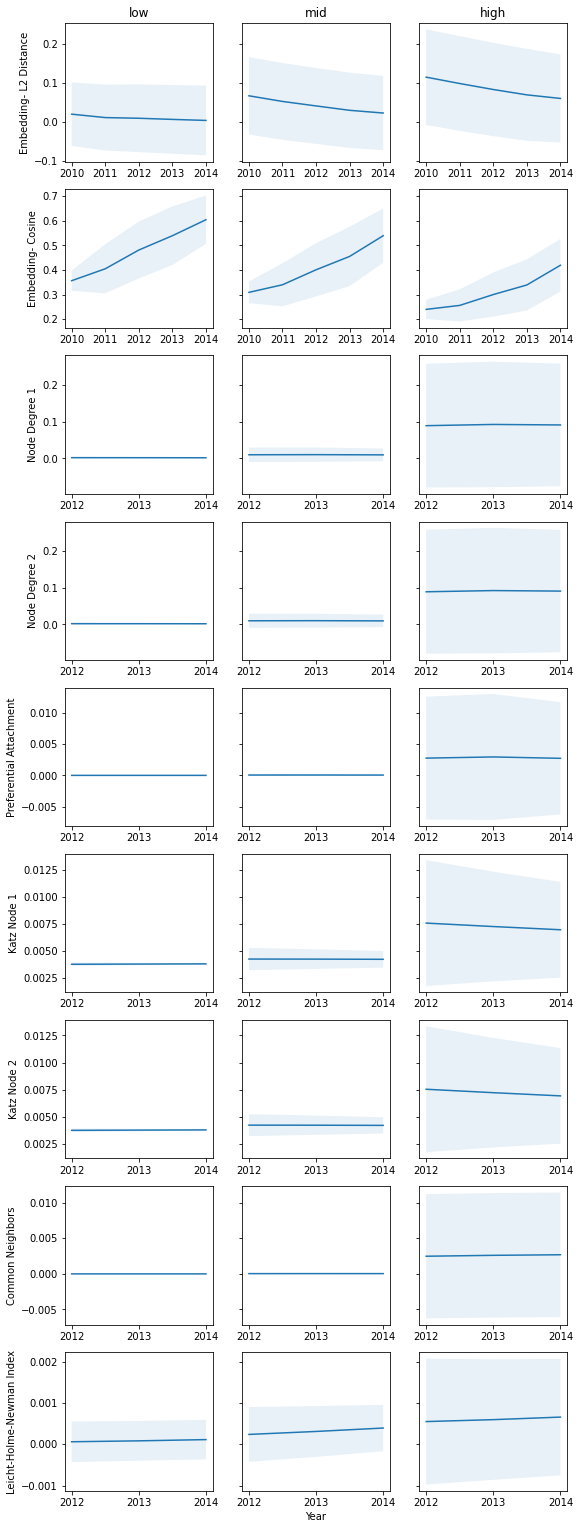

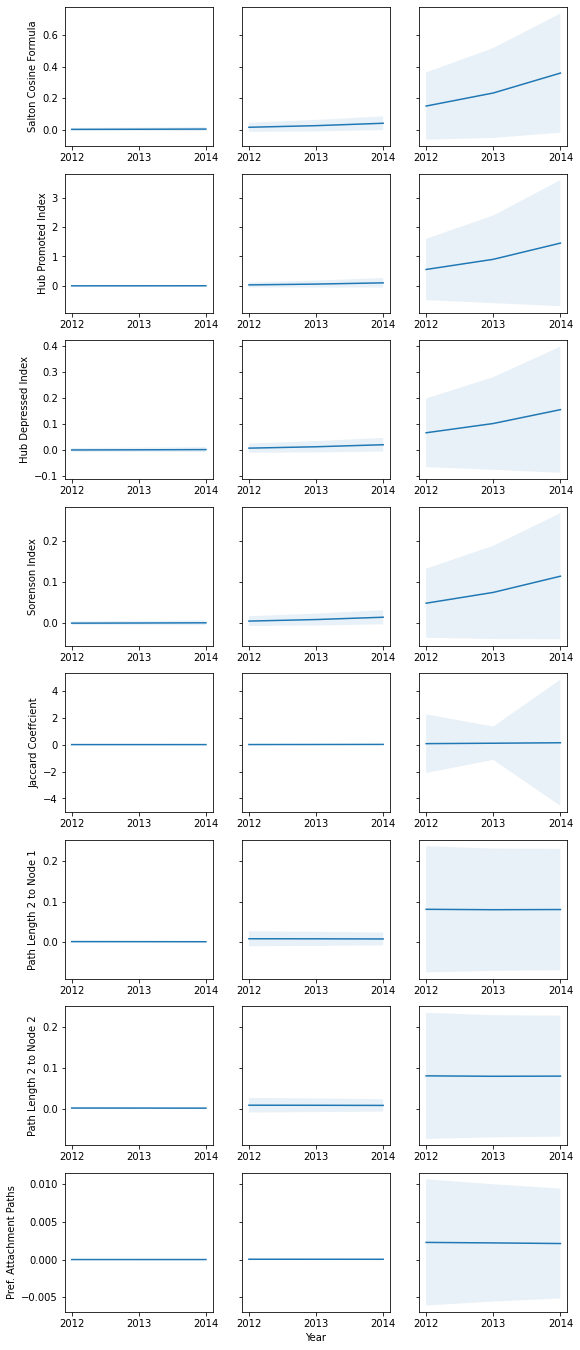

In [9]:
# x_low = np.squeeze(data_test[labels_test==0])
# x_high = np.squeeze(data_test[labels_test>0])
# print(x_low.shape, x_high.shape)

# xs = [x_low, x_high]
# groups = ['no edge', 'edge']

x_low = np.squeeze(data_test[p.ravel()<0.1])
x_mid = np.squeeze(data_test[(p.ravel()>=0.1) & (p.ravel()<0.85)])
x_high = np.squeeze(data_test[p.ravel()>=0.85])

print(x_low.shape, x_mid.shape, x_high.shape)

xs = [x_low, x_mid, x_high]
groups = ['low', 'mid', 'high']
t = range(2014, 2009, -1)

fig, axs = plt.subplots(9, len(groups), sharey='row', figsize=(9,3*9))
c = 0

for ii, x in enumerate(xs):
  axs[c, ii].plot(t, x[:, l2_yrs].mean(axis=0))
  axs[c, ii].fill_between(t, x[:, l2_yrs].mean(axis=0)-x[:, l2_yrs].std(axis=0), x[:, l2_yrs].mean(axis=0)+x[:, l2_yrs].std(axis=0), alpha=0.1)
  axs[c, ii].set_title(groups[ii])
  axs[c, ii].set_xticks(t)
  if ii <1:
    axs[c, ii].set_ylabel('Embedding- L2 Distance')
c += 1 

for ii, x in enumerate(xs):
  axs[c, ii].plot(t, x[:, cos_yrs].mean(axis=0))
  axs[c, ii].fill_between(t, x[:, cos_yrs].mean(axis=0)-x[:, cos_yrs].std(axis=0), x[:, cos_yrs].mean(axis=0)+x[:, cos_yrs].std(axis=0), alpha=0.1)
  axs[c, ii].set_xticks(t)
  if ii <1:
    axs[c, ii].set_ylabel('Embedding- Cosine')
c += 1 

t = range(2014, 2011, -1)

for jj in range(15):
  idx = range(jj, train_features.shape[1], 15)

  for ii, x in enumerate(xs):
    axs[c, ii].plot(t, x[:, idx].mean(axis=0))
    axs[c, ii].fill_between(t, x[:, idx].mean(axis=0)-x[:, idx].std(axis=0), x[:, idx].mean(axis=0)+x[:, idx].std(axis=0), alpha=0.1)
    axs[c, ii].set_xticks(t)
    if ii <1:
      axs[c, ii].set_ylabel(names[jj])
  c += 1 

  if c ==9:
    axs[c-1, 1].set_xlabel('Year')

    plt.subplots_adjust(wspace=0.2)
    plt.savefig(os.path.join(DRIVE_PATH,'features', 'test_features1.pdf'), bbox_inches='tight')
    plt.show()  
    
    fig, axs = plt.subplots(8, len(groups), sharey='row', figsize=(9,3*8))
    c = 0

axs[c-1, 1].set_xlabel('Year')

plt.subplots_adjust(wspace=0.2)
plt.savefig(os.path.join(DRIVE_PATH,'features', 'test_features2.pdf'), bbox_inches='tight')
plt.show()  

# Predict on test set

In [10]:
batch_size = 64

p1 = model.predict(generate_test(data_eval, batch_size), 
                  steps=len(unconnected_vertex_pairs)//batch_size+1, 
                  use_multiprocessing=False)

sorted_predictions_eval=np.flip(np.argsort(p1, axis=0))   
print(p1[sorted_predictions_eval[0]], p1[sorted_predictions_eval[-1]])
print(p1[:15])
print(sum(p1>0.9)/len(unconnected_vertex_pairs)*100)

[[1.]] [[0.00065967]]
[[0.04508427]
 [0.04249284]
 [0.04330516]
 [0.28475672]
 [0.12783185]
 [0.25297505]
 [0.12636966]
 [0.04594761]
 [0.03687608]
 [0.18260318]
 [0.05348432]
 [0.06659943]
 [0.15367356]
 [0.24212557]
 [0.10885024]]
[0.7851]


(612197, 55) (376775, 55) (11028, 55)


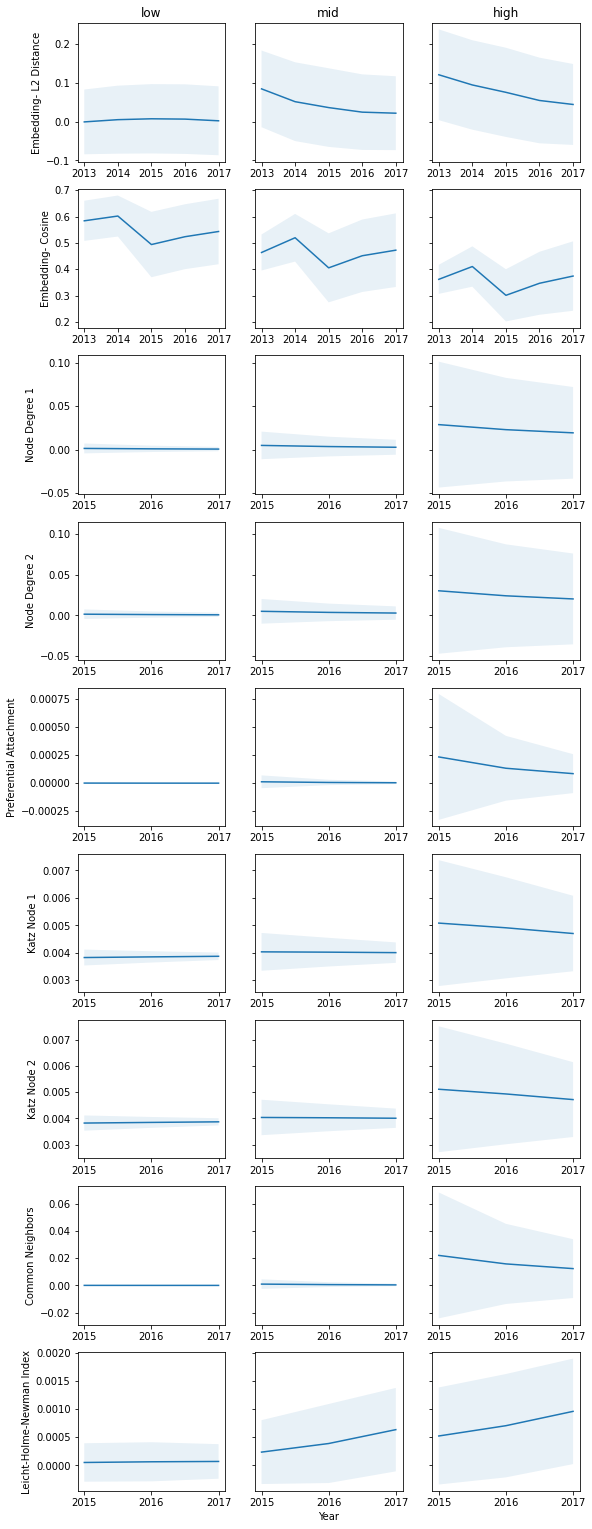

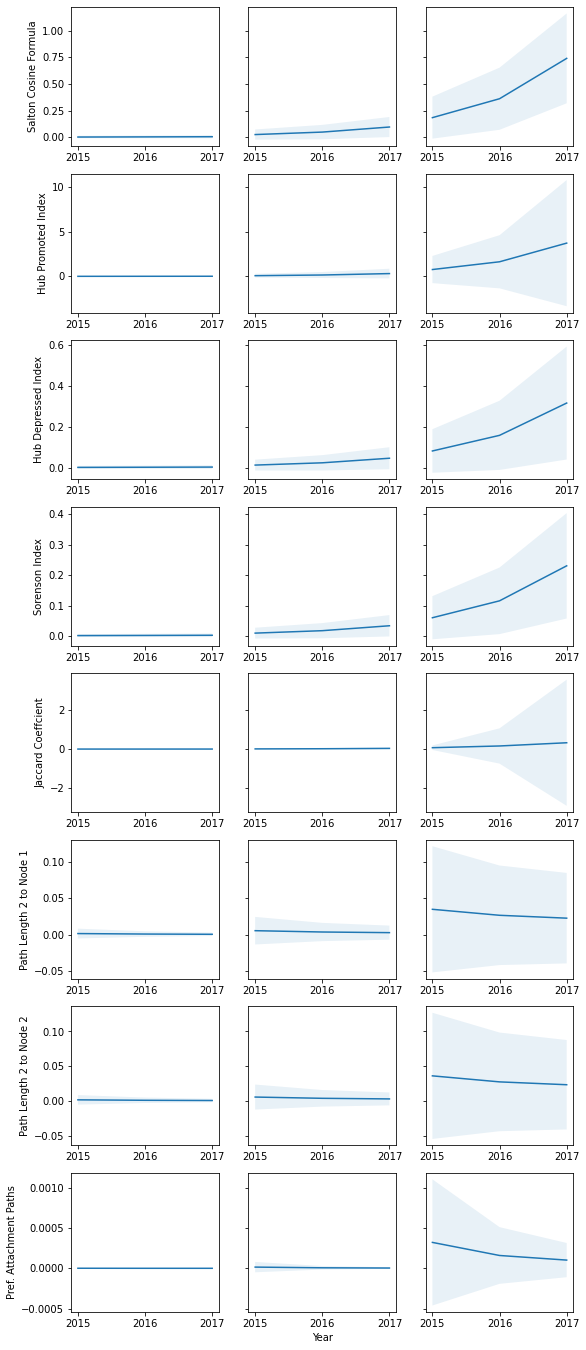

In [11]:
x_low = np.squeeze(data_eval[p1.ravel()<0.1])
x_mid = np.squeeze(data_eval[(p1.ravel()>=0.1) & (p1.ravel()<0.85)])
x_high = np.squeeze(data_eval[p1.ravel()>=0.85])
print(x_low.shape, x_mid.shape, x_high.shape)

xs = [x_low, x_mid, x_high]
groups = ['low', 'mid', 'high']
t = range(2017, 2012, -1)

fig, axs = plt.subplots(9, len(groups), sharey='row', figsize=(9,3*9))
c = 0

for ii, x in enumerate(xs):
  axs[c, ii].plot(t, x[:, l2_yrs].mean(axis=0))
  axs[c, ii].fill_between(t, x[:, l2_yrs].mean(axis=0)-x[:, l2_yrs].std(axis=0), x[:, l2_yrs].mean(axis=0)+x[:, l2_yrs].std(axis=0), alpha=0.1)
  axs[c, ii].set_title(groups[ii])
  axs[c, ii].set_xticks(t)
  if ii <1:
    axs[c, ii].set_ylabel('Embedding- L2 Distance')
c += 1 

for ii, x in enumerate(xs):
  axs[c, ii].plot(t, x[:, cos_yrs].mean(axis=0))
  axs[c, ii].fill_between(t, x[:, cos_yrs].mean(axis=0)-x[:, cos_yrs].std(axis=0), x[:, cos_yrs].mean(axis=0)+x[:, cos_yrs].std(axis=0), alpha=0.1)
  axs[c, ii].set_xticks(t)
  if ii <1:
    axs[c, ii].set_ylabel('Embedding- Cosine')
c += 1 

t = range(2017, 2014, -1)

for jj in range(15):
  idx = range(jj, train_features.shape[1], 15)

  for ii, x in enumerate(xs):
    axs[c, ii].plot(t, x[:, idx].mean(axis=0))
    axs[c, ii].fill_between(t, x[:, idx].mean(axis=0)-x[:, idx].std(axis=0), x[:, idx].mean(axis=0)+x[:, idx].std(axis=0), alpha=0.1)
    axs[c, ii].set_xticks(t)
    if ii <1:
      axs[c, ii].set_ylabel(names[jj])

  c += 1 
  if c ==9:
    axs[c-1, 1].set_xlabel('Year')

    plt.subplots_adjust(wspace=0.2)
    plt.savefig(os.path.join(DRIVE_PATH,'features', 'eval_features1.pdf'), bbox_inches='tight')
    plt.show()  
    
    fig, axs = plt.subplots(8, len(groups), sharey='row', figsize=(9,3*8))
    c = 0

axs[c-1, 1].set_xlabel('Year')

plt.subplots_adjust(wspace=0.2)
plt.savefig(os.path.join(DRIVE_PATH,'features', 'eval_features2.pdf'), bbox_inches='tight')
plt.show()  